# Gaussian Mixture Model

Consider a set of data containing a mixture of $K$ 1d-gaussians with different $\mu_k$ and $\sigma_k$. Denote $z_i$ as the particular gaussian that the i-th particle comes from, which is modeled as Dirichlet distribution with some fixed parameter $\alpha$.  
Mathematically, 

\begin{gather*}
z_i \sim \text{Categorical}(\pi)\\
\pi \sim Dir(\alpha)\\
x_i|\mathbf{\mu}, z_i \sim \mathcal{N}(\mathbf{c}^T\mathbf{\mu}, \mathbf{\sigma})
\end{gather*}

Let's visualize the data.

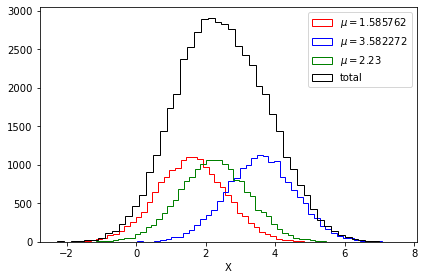

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

X, y, centers = datasets.make_blobs(n_samples=50000, n_features=1, centers=3, center_box=(-5,7), return_centers=True, random_state=0)
bins = 50
fig, ax = plt.subplots()
ax.hist(X[np.where(y==0)], bins=bins, color='r', histtype='step', label=f'$\mu=${centers[0][0]:2f}')
ax.hist(X[np.where(y==1)], bins=bins, color='b', histtype='step', label=f'$\mu=${centers[1][0]:2f}')
ax.hist(X[np.where(y==2)], bins=bins, color='g', histtype='step', label=f'$\mu=${centers[2][0]:.2f}')
ax.hist(X, bins=bins, color='k', label='total', histtype='step')
ax.set(xlabel='X')
ax.legend()
plt.tight_layout()

As seen from the figure, the data we can observe would be the sum of the gaussian distributions. If these gaussians are close then we could not distinguish them from being one gaussian or a mixture of gaussian. Our goal, as usual, is to calculate the posterior given the data. The problem would be as easy as one single gaussian if we know which gaussian each data point comes from. In reality we don't, thus we need to introduce the latent variables.

## Mean field Variational inference for GMM
 In our case, we know or we want to group the data into $K$ gaussian, what we want to learn is the posterior for variable $X$, latent variables $Z$ which tells us which gaussian it belongs to, and finally $\pi$ the pdf of these gaussians. Our probablistic model is
\begin{equation*}
p(X, Z, \pi|\mu, \sigma) = p(\pi)\prod_{i=1}^{N} p(z_i|\pi) p(x_i|z_i,\mu,\sigma) = Dir(\pi|\alpha) \prod_{i=1}^N \prod_{k=1}^K \big[\pi_k \mathcal{N}(x_i|\mu_k, \sigma_k)\big]^{z_{ik}}
\end{equation*}
Note that $z_{ik}$ is either 1 or 0 to pick the gaussian from which the data point belongs to.

#### Test for conjugacy
First, we need to verify that GMM satisfy conditional conjugacy. Namely, if we fix $Z$, the prior has the form
\begin{gather*}
\text{prior:} \qquad p(\pi,Z) = p(\pi) \prod_{i=1}^N p(z_i|\pi) = Dir(\pi|\alpha) \prod_{i=1}^N\prod_{k=1}^K \pi_k^{z_{ik}} = C\prod_{k=1}^K \pi_k^C \\
\text{posterior:} \qquad p(Z,\pi|X) \propto p(X,Z,\pi) = Dir(\pi|\alpha)  \prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}} \pi_k^{z_{ik}} = C\prod_{k=1}^K \pi_k^C
\end{gather*}

where $\prod_{i=1}^N \pi_k^{z_{ik}} \rightarrow \prod_{i=1}^N \pi_k^C \rightarrow \pi_k^C$, all C represent differenet constants. If we fix $\pi$, then
\begin{gather*}
\text{prior:} \qquad p(\pi,Z) = p(\pi) \prod_{i=1}^N p(z_i|\pi) = Dir(\pi|\alpha) \prod_{i=1}^N\prod_{k=1}^K \pi_k^{z_{ik}} = C\prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}} \\
\text{posterior:} \qquad p(Z,\pi|X) \propto p(X,Z,\pi) = Dir(\pi|\alpha)  \prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}} \pi_k^{z_{ik}} = C \prod_{i=1}^N\prod_{k=1}^K C^{z_{ik}}
\end{gather*}
Therefore, it is ok to apply block coordinate ascent. Next we proceed to get the update rule for $q(Z)$ and $q(\pi)$.

## EM Algorithm
In a mean-field approximation, we neglect any correlation between the latent variables, very much like the mean-field approximation in many body problem which allows us to diagonalize the Hamiltonian. Mathematically, $q(Z,\pi) = q(Z)q(\pi)$. Here, the model involves X, latent variables Z and $\pi$ and parameters of the gaussians. In case like this, it is suggested to use the Expectation-Maximization (EM) algorithm in which the E-step updates the pdf of latent variables (using Coordinate Ascent for Variational Inference) and the M-step optimizes the parameters. In this ipynb, I take this approach as axiom and possibly will study the 'proof' later. 

#### E-step : Update Rule for $q(Z)$ and $q(\pi)$
The alogorithm of "Coordinate Ascent for Variational Inference" tells us the update rule for each latent variables : 
\begin{equation*}
q_k(\theta_k) \propto \exp\bigg[\mathbb{E}_{q_{-k}(\theta_{-k})}\log p(\theta,x) \bigg]
\end{equation*}

In our case, 
\begin{align*}
\log q(\pi) &= \mathbb{E}_{q(Z)}\log p(X, Z, \pi) + \text{const} \\ 
&= \mathbb{E}_{q(Z)} \bigg[ \sum_{k=1}^K (\alpha_k-1)\log \pi_k + \sum_{i=1}^N\sum_{k=1}^K z_{ik}\log \pi_k \bigg] + \text{const}\\
&= \sum_{k=1}^K (\alpha_k-1)\log \pi_k + \sum_{i=1}^N\sum_{k=1}^K \mathbb{E}_{q(Z)}z_{ik} \log \pi_k + \text{const} \\
&= \sum_{k=1}^K \log \pi_k \bigg( \alpha_k -1 + \sum_{i=1}^N \mathbb{E}_{q(Z)}z_{ik} \bigg) + \text{const}
\end{align*}

where we have used the relation $Dir(\pi|\alpha) \propto \prod_{k=1}^K \pi_k^{\alpha_k-1}$ before taking the log. Due to the conditional conjugacy $q(\pi)$ would have the same form as prior and thus we get the update rule :
\begin{gather*}
q(\pi) = Dir(\pi | \alpha')\\
\alpha_k' = \alpha_k + \sum_{i=1}^N \mathbb{E}_{q(Z)} z_{ik}  = \alpha_k + \sum_{i=1}^N q(z_{ik}=1)
\end{gather*}




The update rule for $q(Z)$:
\begin{align*}
    \log q(Z) &= \mathbb{E}_{q(\pi)}\log p(X, Z, \pi) + \text{const} \\ 
    &= \mathbb{E}_{q(\pi)} \sum_{i=1}^N\sum_{k=1}^K z_{ik}\bigg[\log \pi_k + \log \mathcal{N}(x_i| \mu_k,\sigma_k) \bigg] + \text{const}\\
    &= \sum_{i=1}^N\sum_{k=1}^K z_{ik}\bigg[\mathbb{E}_{q(\pi)} \log \pi_k + \log \mathcal{N}(x_i| \mu_k,\sigma_k) \bigg] + \text{const} \\
    &= \sum_{i=1}^N\sum_{k=1}^K z_{ik}\log \rho_{ik} + \text{const}
\end{align*} 

where we denote $\log \rho_{ik} = \mathbb{E}_{q(\pi)} \log \pi_k + \log \mathcal{N}(x_i| \mu_k,\sigma_l)$ since again by conjugacy we know $q(Z)$ is categorical. We can see that 
\begin{gather*}
q(Z)\propto \prod_{i=1}^N\prod_{k=1}^K \rho_{ik}^{z_{ik}}
\end{gather*}

We can then normalize by using $\sum_{k=1}^K p(z_{ik}=1) = \sum_{k=1}^K \rho_{ik}= 1$, i.e.
\begin{gather*}
q(Z)= \prod_{i=1}^N\prod_{k=1}^K \bigg(\frac{\rho_{ik}}{\sum_{l=1}^K \rho_{il}}\bigg)^{z_{ik}} \\
\log \rho_{ik} = \mathbb{E}_{q(\pi)} \log \pi_k + \log \mathcal{N}(x_i|\mu_k,\sigma_k)
\end{gather*}

Note that
- the expectation term in $\rho_{ik}$ can be calculated with the update rule of $q(\pi)$. 
- the expectaton of Dirichlet distribution is given by di-gamma function $\psi(\alpha_k) - \psi(\sum_i \alpha_i)$

#### M-step : Maximize ELBO with respect to parameters
In M-step, we use the $q(Z)$ found in E-step to optimize:
\begin{equation*}
\theta^{\text{NEW}} = \argmax_{\theta} \mathbb{E}_{p(Z)} \log p(X,Z; \theta)
\end{equation*}
The expectation value, dropping the term independent of $\mu, \sigma$, is
\begin{align*}
\mathbb{E}_{p(Z,\pi)} \log p(X,Z,\pi; \mu, \sigma) &= \mathbb{E}_{p(Z,\pi)} \log\bigg( Dir(\pi|\alpha) \prod_{i=1}^N \prod_{k=1}^K \big[\pi_k \mathcal{N}(x_i|\mu_k, \sigma_k)\big]^{z_{ik}}\bigg) \\
&= \mathbb{E}_{p(Z,\pi)} \bigg[ \log Dir(\pi|\alpha) + \sum_{i=1}^N\sum_{k=1}^K z_{ik}\log\pi_k + z_{ik}\log \mathcal{N}(x_i|\mu_k,\sigma_k) \bigg]\\
&= \sum_{i=1}^N\sum_{k=1}^K \mathbb{E}_{p(Z)}z_{ik}\log \mathcal{N}(x_i|\mu_k,\sigma_k) + \text{const}\\
&=\sum_{i=1}^N\sum_{k=1}^K \mathbb{E}_{p(Z)}z_{ik} \bigg( -\log \sigma_k - \frac{(x_i-\mu_k)^2}{2\sigma_k^2}\bigg) + \text{const}\\
&=\sum_{i=1}^N\sum_{k=1}^K\gamma_{ik} \bigg( -\log \sigma_k - \frac{(x_i-\mu_k)^2}{2\sigma_k^2}\bigg) + \text{const} \\
&= \sum_{i=1}^N\sum_{k=1}^K\gamma_{ik} \bigg( \frac{1}{2}\log \lambda_k - \frac{(x_i-\mu_k)^2}{2}\lambda_k\bigg) + \text{const}
\end{align*}


The expectation of Dirichlet distribution does not depend on $\mu$ and $\sigma$, thus is regarded as constant. Variate with respect to $\mu_k$, 
\begin{align*}
\sum_{i=1}^N\gamma_{ik} \frac{x_i-\mu_k}{\sigma_k^2} = 0 \implies \mu_k = \frac{\sum_{i=1}^N \gamma_{ik}x_i}{\sum_{i=1}^N\gamma_{ik}}
\end{align*}


Variate with respect to $\lambda_k = 1/\sigma_k^2$,
\begin{align*}
\sum_{i=1}^N\gamma_{ik}\bigg(\frac{1}{\lambda_k} - (x_i-\mu_k)^2\bigg) = 0 \implies \lambda_k = \frac{\sum_{i=1}^N\gamma_{ik}}{\sum_{i=1}^N\gamma_{ik}(x_i-\mu_k)^2}
\end{align*}

#### Implementation of "GMM with Dirichlet Prior"

- inialize $q(Z)$ and $\alpha$ 
- initialize ELBO (optional)
- while not converged: 
    - E-step : update $\alpha$, $q(Z)$ 
    - M-step : update $\mu$, $\lambda$ 
    - break if change in ELBO < tolerance

Here, I will write a short code to implement the algorithm to test on 1D data generated above. In the next note, I will write a more detailed version to cover multi-dimensional case and add back the basic GMM, very much like the sklearn GMM. 

In [27]:
from scipy.stats import multivariate_normal
from scipy.special import digamma

class Dirichlet_GMM1D:
    def __init__(self, n_components=1, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter

    def fit(self, X):
        self._initialize(X)

        for it in range(self.max_iter):
            self._e_step(X)
            self._m_step(X)
        
    def _initialize(self, X):
        n_samples, _ = X.shape
        self.alpha = np.full(shape=self.n_components, fill_value=1./self.n_components)
        self.qz = np.zeros(shape=(n_samples, self.n_components))
        for n in range(n_samples):
            k = np.random.randint(0, self.n_components)
            self.qz[n][k] = 1

        indices = np.random.randint(0, n_samples, size=self.n_components)
        self.means_ = [X[i] for i in indices]
        self.precisions_ = [1./np.var(X) for _ in range(self.n_components)]
        

    def _e_step(self, X):

        nk = np.sum(self.qz, axis=0)
        for k in range(self.n_components):
            self.alpha[k] += nk[k]
        
        likelihood = np.zeros(shape=self.qz.shape)
        for k in range(self.n_components):
            distribution = multivariate_normal(mean=self.means_[k], cov=1./self.precisions_[k])
            likelihood[:, k] = digamma(self.alpha[k]) - digamma(np.sum(self.alpha)) + np.log(distribution.pdf(X))

        numerator = np.exp(likelihood)
        denominator = np.sum(numerator, axis=1)[:, np.newaxis]
        self.qz = numerator / denominator

        
    def _m_step(self, X):
        nk = np.sum(self.qz, axis=0)

        self.means_ = np.dot(self.qz.T, X) / nk[:, np.newaxis]
        var = np.empty(shape=self.n_components)
        for k in range(self.n_components):
            diff = X - self.means_[k]
            var[k] = np.dot(self.qz[:, k] * diff.T, diff) / nk[k]
        self.precisions_ = 1. / var

In [25]:
gmm = Dirichlet_GMM1D(3, 1000)
gmm.fit(X)

print(gmm.means_)
print(centers)

[[3.45178719]
 [1.69957529]
 [2.08488072]]
[[1.58576205]
 [3.5822724 ]
 [2.23316051]]
